In [1]:
import sys
sys.path.append("../")

In [2]:
import pandas as pd
import plotly.graph_objects as go
from technicals.indicators import RSI
from technicals.patterns import apply_patterns
from plotting import CandlePlot
import numpy as np

from infrastructure.quotehistory_collection import quotehistoryCollection as qc
from simulation.ema_cross_multi_temporal_tester import EmaCrossMultiTemporalTester

In [3]:
# Função para calcular o Kairi Relative Index (KRI)
def calculate_kri(close_prices, p_kri, kri_ema_s, kri_ema_l):
    # Calcula a média móvel simples (SMA)
    # sma = close_prices.rolling(window=period).mean()
    sma = close_prices.ewm(span=p_kri, min_periods=p_kri).mean()
    
    # Calcula o Kairi Relative Index (KRI)
    kri = ((close_prices - sma) / sma) * 100

    kri_ema_short = kri.ewm(span=kri_ema_s, min_periods=kri_ema_s).mean()
    kri_ema_long = kri.ewm(span=kri_ema_l, min_periods=kri_ema_l).mean()
    
    return kri, kri_ema_short, kri_ema_long
    
# Função para calcular a variação percentual acumulada em uma janela
def rolling_percent_change(close_prices, window):
    percent_changes = (close_prices.pct_change() * 100).rolling(window=window).sum()
    return percent_changes

# Função para calcular a EMA
def calculate_ema(data, period):
    return data.ewm(span=period, adjust=False).mean()

# Função principal que calcula a variação percentual acumulada e as duas EMAs
def rolling_percent_change_with_two_emas(close_prices, window=14, ema_period_1=10, ema_period_2=60):
    # Calcula a variação percentual acumulada
    percent_change_buffer = rolling_percent_change(close_prices, window)

    # Calcula as duas EMAs
    ema1 = calculate_ema(percent_change_buffer, ema_period_1)
    ema2 = calculate_ema(percent_change_buffer, ema_period_2)

    return percent_change_buffer, ema1, ema2

In [4]:
BUY = 1
SELL = -1
NONE = 0

def apply_signal_short(row):
    if row.SPREAD < 50 and row.SIGNAL > 0 and row.DELTA_SHORT >= 0 and row.DELTA_SHORT_PREV < 0:
        return BUY
    elif row.SPREAD < 50 and row.SIGNAL < 0 and row.DELTA_SHORT < 0 and row.DELTA_SHORT_PREV >= 0:
        return SELL
    return NONE
    
def apply_signal_long(row):
    if row.DELTA >= 0 and row.DELTA_PREV < 0:
        return BUY
    elif row.DELTA < 0 and row.DELTA_PREV >= 0:
        return SELL
    return NONE

def apply_signal_kri(row):
    if row.KRI < -1 and row.DELTA_KRI >= 0 and row.DELTA_PREV_KRI < 0:
        return BUY
    elif row.KRI > 1 and row.DELTA_KRI < 0 and row.DELTA_PREV_KRI >= 0:
        return SELL
    return NONE

In [5]:
def run_pair(pair,pip_value,use_spread=True,stop_loss = 1000, take_profit = 200, fixed_tp_sl=True):
    df_an = pd.read_pickle(f"../data/H4/{pair}_H4.pkl")
    df_m5 = pd.read_pickle(f"../data/M5/{pair}_M5.pkl")
    df_an.reset_index(drop=True, inplace=True)
    df_m5.reset_index(drop=True, inplace=True)
    p_kri, kri_ema_s, kri_ema_l = 20,3,50
    # df_an['KRI'], df_an[f'KRI_EMA_{kri_ema_s}'], df_an[f'KRI_EMA_{kri_ema_l}'] = calculate_kri(df_an['mid_c'], p_kri, kri_ema_s, kri_ema_l)
    # # df_an['DELTA_KRI'] = df_an[f'KRI_EMA_{kri_ema_s}'] - df_an[f'KRI_EMA_{kri_ema_l}']
    # df_an['DELTA_KRI'] = df_an[f'KRI'] - df_an[f'KRI_EMA_{kri_ema_s}']
    # df_an['DELTA_PREV_KRI'] = df_an.DELTA_KRI.shift(1)
    ema_1 = 10
    ema_2 = 30
    df_an[f'EMA_{ema_1}'] = df_an.mid_c.ewm(span=ema_1, min_periods=ema_1).mean()
    df_an[f'EMA_{ema_2}'] = df_an.mid_c.ewm(span=ema_2, min_periods=ema_2).mean()
    df_an['donchian_high'] = df_an['mid_c'].rolling(window=20).max()
    df_an['donchian_low'] = df_an['mid_c'].rolling(window=20).min()
    df_an['DELTA'] = df_an[f'EMA_{ema_1}'] - df_an[f'EMA_{ema_2}']
    df_an['DELTA_PREV'] = df_an.DELTA.shift(1)
    df_slim = df_an.copy()
    df_slim.dropna(inplace=True)
    df_slim.reset_index(drop=True, inplace=True)

    ema_1 = 10
    ema_2 = 30
    df_m5[f'EMA_SHORT_1'] = df_m5.mid_c.ewm(span=ema_1, min_periods=ema_1).mean()
    df_m5[f'EMA_SHORT_2'] = df_m5.mid_c.ewm(span=ema_2, min_periods=ema_2).mean()
    df_m5['donchian_high_short'] = df_m5['mid_c'].rolling(window=100).max()
    df_m5['donchian_low_short'] = df_m5['mid_c'].rolling(window=100).min()
    df_m5['DELTA_SHORT'] = df_m5[f'EMA_SHORT_1'] - df_m5[f'EMA_SHORT_2']
    df_m5['DELTA_SHORT_PREV'] = df_m5.DELTA_SHORT.shift(1)
    df_m5['SPREAD'] = (df_m5[f'ask_c'] - df_m5[f'bid_c']) / pip_value
    df_m5.dropna(inplace=True)
    df_m5.reset_index(drop=True, inplace=True)

    gt = EmaCrossMultiTemporalTester(
        df_slim,
        apply_signal_long,
        apply_signal_short,
        pip_value,
        df_m5,
        use_spread=use_spread,
        LOSS_FACTOR = stop_loss,
        PROFIT_FACTOR = take_profit,
        fixed_tp_sl=fixed_tp_sl
    )
    
    gt.run_test()
    return gt

In [6]:

pip1 = 0.0001
pip2 = 0.01
SL1 = [100,500]
TP1 = [100,500]
TP2 = [100,500,1000]
SL2 = [500,1000,2000]
pairs_pip_size = {
    "EURUSD": { 
        "pip": pip1,
        "SL": SL1,
        "TP": TP1,
    },
    "GBPUSD": { 
        "pip": pip1,
        "SL": SL1,
        "TP": TP1,
    },
    "USDCHF": { 
        "pip": pip1,
        "SL": SL1,
        "TP": TP1,
    },
    "AUDUSD": { 
        "pip": pip1,
        "SL": SL1,
        "TP": TP1,
    },
    "USDCAD": { 
        "pip": pip1,
        "SL": SL1,
        "TP": TP1,
    },
    "NZDUSD": { 
        "pip": pip1,
        "SL": SL1,
        "TP": TP1,
    },
    "EURGBP": { 
        "pip": pip1,
        "SL": SL1,
        "TP": TP1,
    },
    "USDJPY": { 
        "pip": pip2,
        "SL": SL2,
        "TP": TP2,
    },
    "EURJPY": { 
        "pip": pip2,
        "SL": SL2,
        "TP": TP2,
    },
    "GBPJPY": { 
        "pip": pip2,
        "SL": SL2,
        "TP": TP2,
    },
    "XAUUSD": { 
        "pip": pip2,
        "SL": SL2,
        "TP": TP2,
    },
    "BTCUSD": { 
        "pip": pip2,
        "SL": SL2,
        "TP": TP2,
    },
    "ETHUSD": { 
        "pip": pip2,
        "SL": SL2,
        "TP": TP2,
    },
    "BTCEUR": { 
        "pip": pip2,
        "SL": SL2,
        "TP": TP2,
    },
    "ETHEUR": { 
        "pip": pip2,
        "SL": SL2,
        "TP": TP2,
    },
}


# pairs_pip_size = {
#     "EURUSD": 0.0001,
# }

In [7]:
pairs_pip_size['USDCHF']['TP']

[100, 500]

In [ ]:
qc.LoadQuotehistory("../data")

# SL = [1000,2000,3000,4000]
# TP = [100,200,300,500,1000]

# SL = [100]
# TP = [100]

res = []
for pair in pairs_pip_size:
    if pair in qc.quotehistory_dict.keys():
        print("\n\n")
        print(f" Pair ---------> {pair}")
        pip_size = pairs_pip_size[pair]['pip']
        for sl in pairs_pip_size[pair]['SL']:
            for tp in pairs_pip_size[pair]['TP']:
                print("\n")
                print(f"SL => {sl} | TP => {tp}")
                res.append(
                    dict(
                        pair=pair,
                        stop_loss=sl,
                        take_profit=tp,
                        res=run_pair(
                            pair,
                            pip_size,
                            use_spread=True,
                            stop_loss=sl,
                            take_profit=tp,
                            fixed_tp_sl=True
                        )
                    )
                )
                




 Pair ---------> EURUSD


SL => 100 | TP => 100
prepare_data...
run_test...
Result: 23320.100000000188


SL => 100 | TP => 500
prepare_data...
run_test...
Result: -17063.600000000035


SL => 500 | TP => 100
prepare_data...
run_test...
Result: 28420.60000000015


SL => 500 | TP => 500
prepare_data...
run_test...
Result: -18074.700000000063



 Pair ---------> GBPUSD


SL => 100 | TP => 100
prepare_data...
run_test...
Result: 64503.69999999984


SL => 100 | TP => 500
prepare_data...
run_test...
Result: 7509.299999999588


SL => 500 | TP => 100
prepare_data...
run_test...
Result: 76068.89999999972


SL => 500 | TP => 500
prepare_data...
run_test...
Result: -10786.70000000055



 Pair ---------> USDCHF


SL => 100 | TP => 100
prepare_data...
run_test...
Result: 39429.90000000019


SL => 100 | TP => 500
prepare_data...
run_test...
Result: 84734.70000000023


SL => 500 | TP => 100
prepare_data...
run_test...
Result: 45989.80000000018


SL => 500 | TP => 500
prepare_data...
run_test...
Res

In [ ]:
(1.23786-1.24868)/0.0001

In [ ]:
res[0]['res']

In [ ]:
import json
data = json.dumps(res)
with open('data.json', 'w') as f:
    json.dump(data, f)

In [29]:
merged = res[0]['res'].merged
print(merged.columns)


Index(['time', 'bid_c', 'bid_h', 'bid_l', 'bid_o', 'ask_c', 'ask_h', 'ask_l',
       'ask_o', 'mid_c', 'mid_h', 'mid_l', 'mid_o', 'EMA_SHORT_1',
       'EMA_SHORT_2', 'SPREAD', 'donchian_high_short', 'donchian_low_short',
       'DELTA_SHORT', 'DELTA_SHORT_PREV', 'mid_c_long', 'EMA_10', 'EMA_30',
       'donchian_high', 'donchian_low', 'DELTA', 'DELTA_PREV', 'SIGNAL',
       'SIGNAL_SHORT', 'TP', 'SL', 'SL_VALUE'],
      dtype='object')


In [30]:

merged_slim = merged[['time','mid_c','ask_c','bid_c','SPREAD','SIGNAL', 'SIGNAL_SHORT', 'TP','SL', 'SL_VALUE']].copy()


In [31]:
for r in res:
    print(r['pair'], r['res'].df_results.result.sum())

EURUSD 23320.100000000188


In [32]:
df_results = res[0]['res'].df_results
pair = res[0]['pair']
print(pair)
res_pos = df_results[df_results['result'] > 0]
res_neg = df_results[df_results['result'] < 0]
df_results.shape, res_pos.shape, res_neg.shape

EURUSD


((9198, 16), (3576, 16), (5618, 16))

In [33]:
df_results.describe()

,start_index_m5,profit_factor,loss_factor,pip_value,SL_value,count,start_price,trigger_price,SIGNAL,SIGNAL_SHORT,TP,SL,result,end_time,start_time
count,9198.000000,9198.0,9198.0,9.198000e+03,9198.0,9198.000000,9198.000000,9198.000000,9198.000000,9198.000000,9198.000000,9198.000000,9198.000000,9198,9198
mean,247324.336160,100.0,100.0,1.000000e-04,100.0,737.538704,1.123087,1.123159,-0.057621,-0.057621,1.122510,1.123663,2.535345,2021-05-02 16:59:30.613176832,2021-04-29 04:47:03.483366144
min,87.000000,100.0,100.0,1.000000e-04,100.0,2.000000,0.953990,0.953630,-1.000000,-1.000000,0.943980,0.963980,-100.000000,2018-01-08 14:40:00,2018-01-02 15:30:00
25%,122670.500000,100.0,100.0,1.000000e-04,100.0,294.000000,1.084862,1.086710,-1.000000,-1.000000,1.081552,1.086100,-50.600000,2019-08-24 16:00:00,2019-08-23 23:52:30
50%,247003.000000,100.0,100.0,1.000000e-04,100.0,607.000000,1.117630,1.117080,-1.000000,-1.000000,1.117010,1.118780,-17.650000,2021-05-05 07:15:00,2021-04-28 08:50:00
75%,371030.500000,100.0,100.0,1.000000e-04,100.0,1053.000000,1.168175,1.167330,1.000000,1.000000,1.166008,1.167775,100.000000,2023-01-03 09:00:00,2022-12-28 09:22:30
max,498422.000000,100.0,100.0,1.000000e-04,100.0,3885.000000,1.251050,1.253780,1.000000,1.000000,1.261050,1.250070,100.000000,2024-09-13 01:00:00,2024-09-12 11:55:00
std,143983.676082,0.0,0.0,2.710653e-20,0.0,567.719987,0.056872,0.056809,0.998393,0.998393,0.058863,0.056603,72.151158,NaN,NaN


In [34]:
df_results.result.sum()

np.float64(23320.100000000188)

In [35]:
sum_neg = res_neg.result.sum()
sum_neg, sum_neg/res_neg.shape[0]

(np.float64(-273715.2999999998), np.float64(-48.72112851548591))

In [46]:

res_neg.iloc[100:110]


,running,start_index_m5,profit_factor,loss_factor,pip_value,SL_value,count,start_price,trigger_price,SIGNAL,SIGNAL_SHORT,TP,SL,result,end_time,start_time
237,False,11950,100,100,0.0001,100.0,493,1.22062,1.23165,-1,-1,1.21062,1.23062,-100.0,2018-03-02 13:05:00,2018-02-28 20:05:00
238,False,11971,100,100,0.0001,100.0,472,1.22032,1.23165,-1,-1,1.21032,1.23032,-100.0,2018-03-02 13:05:00,2018-02-28 21:50:00
239,False,11808,100,100,0.0001,100.0,636,1.22202,1.23225,-1,-1,1.21202,1.23202,-100.0,2018-03-02 13:10:00,2018-02-28 08:15:00
240,False,11829,100,100,0.0001,100.0,615,1.22170,1.23225,-1,-1,1.21170,1.23170,-100.0,2018-03-02 13:10:00,2018-02-28 10:00:00
241,False,11878,100,100,0.0001,100.0,566,1.22177,1.23225,-1,-1,1.21177,1.23177,-100.0,2018-03-02 13:10:00,2018-02-28 14:05:00
242,False,11883,100,100,0.0001,100.0,561,1.22167,1.23225,-1,-1,1.21167,1.23167,-100.0,2018-03-02 13:10:00,2018-02-28 14:30:00
243,False,11732,100,100,0.0001,100.0,758,1.22260,1.23274,-1,-1,1.21260,1.23260,-100.0,2018-03-02 17:00:00,2018-02-28 01:55:00
244,False,11742,100,100,0.0001,100.0,749,1.22313,1.23325,-1,-1,1.21313,1.23313,-100.0,2018-03-02 17:05:00,2018-02-28 02:45:00
245,False,11755,100,100,0.0001,100.0,736,1.22287,1.23325,-1,-1,1.21287,1.23287,-100.0,2018-03-02 17:05:00,2018-02-28 03:50:00
246,False,11672,100,100,0.0001,100.0,866,1.22428,1.23206,-1,-1,1.21428,1.23428,-77.8,2018-03-02 21:00:00,2018-02-27 20:55:00


In [39]:
merged_slim.iloc[700:710]

,time,mid_c,ask_c,bid_c,SPREAD,SIGNAL,SIGNAL_SHORT,TP,SL,SL_VALUE
700,2018-01-04 18:35:00,1.20693,1.20693,1.20693,0.0,1,0,0.0,0.0,0.0
701,2018-01-04 18:40:00,1.20670,1.20670,1.20670,0.0,1,0,0.0,0.0,0.0
702,2018-01-04 18:45:00,1.20640,1.20640,1.20640,0.0,1,0,0.0,0.0,0.0
703,2018-01-04 18:50:00,1.20631,1.20631,1.20631,0.0,1,0,0.0,0.0,0.0
704,2018-01-04 18:55:00,1.20631,1.20631,1.20631,0.0,1,0,0.0,0.0,0.0
705,2018-01-04 19:00:00,1.20646,1.20646,1.20646,0.0,1,0,0.0,0.0,0.0
706,2018-01-04 19:05:00,1.20630,1.20630,1.20630,0.0,1,0,0.0,0.0,0.0
707,2018-01-04 19:10:00,1.20637,1.20637,1.20637,0.0,1,0,0.0,0.0,0.0
708,2018-01-04 19:15:00,1.20679,1.20679,1.20679,0.0,1,0,0.0,0.0,0.0
709,2018-01-04 19:20:00,1.20641,1.20641,1.20641,0.0,1,0,0.0,0.0,0.0


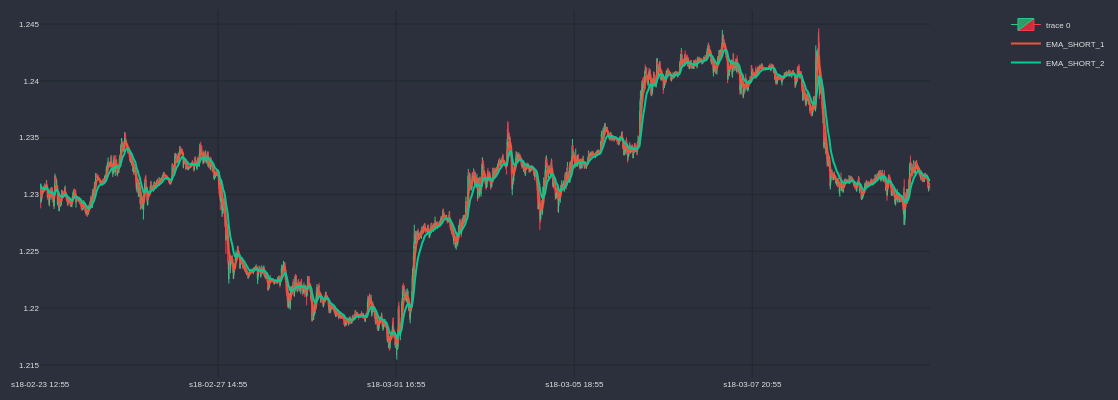

In [52]:
cp = CandlePlot(merged.iloc[11000:14000])
cp.show_plot(line_traces=['EMA_SHORT_1','EMA_SHORT_2'])

In [53]:
ema_1 = 10
ema_2 = 30
df_4h = pd.read_pickle(f"../data/H4/{pair}_H4.pkl")
df_4h[f'EMA_{ema_1}'] = df_4h.mid_c.ewm(span=ema_1, min_periods=ema_1).mean()
df_4h[f'EMA_{ema_2}'] = df_4h.mid_c.ewm(span=ema_2, min_periods=ema_2).mean()

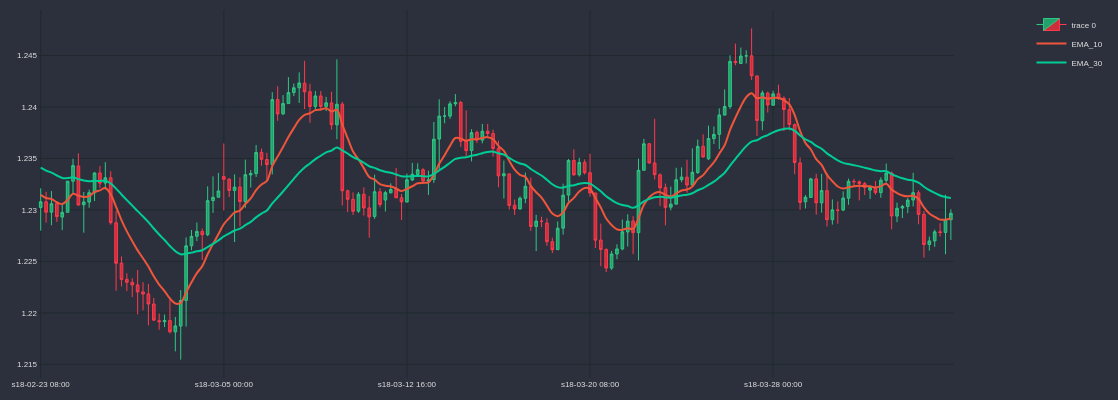

In [55]:

cp = CandlePlot(df_4h.iloc[230:400])
cp.show_plot(line_traces=['EMA_10', 'EMA_30'])


